# Pyspark for Linear Regression

### 1. Set up spark context and SparkSession

In [2]:
from pyspark import SparkConf, SparkContext
## set up spark context
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)
## set up  SparkSession
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### 2. Load dataset

In [5]:
df = sqlContext.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').load("./data/Advertising.csv",header=True);

- check the dataset and the Schema

In [7]:
df.take(2)
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- TV: double (nullable = true)
 |-- Radio: double (nullable = true)
 |-- Newspaper: double (nullable = true)
 |-- Sales: double (nullable = true)



### 3. Convert the data to dense vector

In [11]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

In [12]:
# convert the data to dense vector
def transData(row):
    return Row(label=row["Sales"],
               features=Vectors.dense([
                                       row["TV"],
                                       row["Radio"],
                                       row["Newspaper"]]))

### 4. Transform the dataset to DataFrame

In [13]:
transformed = df.rdd.map(transData).toDF() 
transformed.show()

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[230.1,37.8,69.2]| 22.1|
| [44.5,39.3,45.1]| 10.4|
| [17.2,45.9,69.3]|  9.3|
|[151.5,41.3,58.5]| 18.5|
|[180.8,10.8,58.4]| 12.9|
|  [8.7,48.9,75.0]|  7.2|
| [57.5,32.8,23.5]| 11.8|
|[120.2,19.6,11.6]| 13.2|
|    [8.6,2.1,1.0]|  4.8|
| [199.8,2.6,21.2]| 10.6|
|  [66.1,5.8,24.2]|  8.6|
| [214.7,24.0,4.0]| 17.4|
| [23.8,35.1,65.9]|  9.2|
|   [97.5,7.6,7.2]|  9.7|
|[204.1,32.9,46.0]| 19.0|
|[195.4,47.7,52.9]| 22.4|
|[67.8,36.6,114.0]| 12.5|
|[281.4,39.6,55.8]| 24.4|
| [69.2,20.5,18.3]| 11.3|
|[147.3,23.9,19.1]| 14.6|
+-----------------+-----+
only showing top 20 rows



### 5. Fit model (Ridge Regression and the LASSO)

In [15]:
# Import LinearRegression class
from pyspark.ml.regression import LinearRegression

# Define LinearRegression algorithm
lr = LinearRegression()

# Fit 2 models, using different regularization parameters
modelA = lr.fit(transformed, {lr.regParam:0.0})
modelB = lr.fit(transformed, {lr.regParam:1.0})

In [16]:
 # Make predictions
predictionsA = modelA.transform(transformed)
predictionsA.show()

+-----------------+-----+------------------+
|         features|label|        prediction|
+-----------------+-----+------------------+
|[230.1,37.8,69.2]| 22.1| 20.52397440971517|
| [44.5,39.3,45.1]| 10.4|12.337854820894362|
| [17.2,45.9,69.3]|  9.3|12.307670779994238|
|[151.5,41.3,58.5]| 18.5| 17.59782951168913|
|[180.8,10.8,58.4]| 12.9|13.188671856831299|
|  [8.7,48.9,75.0]|  7.2|12.478347634035858|
| [57.5,32.8,23.5]| 11.8|11.729759951563684|
|[120.2,19.6,11.6]| 13.2| 12.12295316550228|
|    [8.6,2.1,1.0]|  4.8| 3.727340862861585|
| [199.8,2.6,21.2]| 10.6|12.550848722934685|
|  [66.1,5.8,24.2]|  8.6| 7.032299200558857|
| [214.7,24.0,4.0]| 17.4| 17.28512918260026|
| [23.8,35.1,65.9]|  9.2|10.577120733627675|
|   [97.5,7.6,7.2]|  9.7| 8.826300480033199|
|[204.1,32.9,46.0]| 19.0|18.434366383561077|
|[195.4,47.7,52.9]| 22.4|20.819299516495455|
|[67.8,36.6,114.0]| 12.5| 12.82365674369938|
|[281.4,39.6,55.8]| 24.4|23.224957158799008|
| [69.2,20.5,18.3]| 11.3| 9.951682059118799|
|[147.3,23

### 6. Evaluation

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse")
RMSE = evaluator.evaluate(predictionsA)
print("ModelA: Root Mean Squared Error = " + str(RMSE))

ModelA: Root Mean Squared Error = 1.6685701407225701


In [18]:
predictionsB = modelB.transform(transformed)
predictionsB.show()

+-----------------+-----+------------------+
|         features|label|        prediction|
+-----------------+-----+------------------+
|[230.1,37.8,69.2]| 22.1| 19.76875575831641|
| [44.5,39.3,45.1]| 10.4|12.681934421326527|
| [17.2,45.9,69.3]|  9.3|12.831279878059057|
|[151.5,41.3,58.5]| 18.5|17.212685096576116|
|[180.8,10.8,58.4]| 12.9|13.565646466441844|
|  [8.7,48.9,75.0]|  7.2|13.013004013254886|
| [57.5,32.8,23.5]| 11.8|12.015109427517054|
|[120.2,19.6,11.6]| 13.2|12.282357116553044|
|    [8.6,2.1,1.0]|  4.8|  5.16673805973666|
| [199.8,2.6,21.2]| 10.6|12.755472584548897|
|  [66.1,5.8,24.2]|  8.6| 8.123762036616027|
| [214.7,24.0,4.0]| 17.4| 16.56110418166338|
| [23.8,35.1,65.9]|  9.2|11.370966908074013|
|   [97.5,7.6,7.2]|  9.7| 9.497791423923593|
|[204.1,32.9,46.0]| 19.0|17.838038564514186|
|[195.4,47.7,52.9]| 22.4|19.868060781684964|
|[67.8,36.6,114.0]| 12.5|13.636219112847762|
|[281.4,39.6,55.8]| 24.4| 21.93487824178411|
| [69.2,20.5,18.3]| 11.3|10.503997287424209|
|[147.3,23

In [19]:
RMSE = evaluator.evaluate(predictionsB)
print("ModelB: Root Mean Squared Error = " + str(RMSE))

ModelB: Root Mean Squared Error = 1.8390249207444873


### 7. Visualization

In [133]:
# Import numpy, pandas, and ggplot
import numpy as np
from pandas import *
from ggplot import *
 
# Create Python DataFrame
pop = transformed.rdd.map(lambda p: (p.features[0])).collect()
sales = transformed.rdd.map(lambda p: (p.label)).collect()
predA = predictionsA.select("prediction").rdd.map(lambda r: r[0]).collect()
predB = predictionsB.select("prediction").rdd.map(lambda r: r[0]).collect()



pydf = DataFrame([predA]) 
nx,ny = pydf.shape
type1 = Series([0 for x in range(ny)])
type2 = Series([1 for x in range(ny)])

#pydf
# pandas DataFrame    
pydf1 = DataFrame({'pop':pop,'sales':sales,'pred':predA,'type':type1})
pydf2 = DataFrame({'pop':pop,'sales':sales,'pred':predB,'type':type2})

frames = [pydf1, pydf2]

result = pd.concat(frames)
result['type'] = result['type'].astype(object)
result

,pop,pred,sales,type
0,230.1,20.523974,22.1,0
1,44.5,12.337855,10.4,0
2,17.2,12.307671,9.3,0
3,151.5,17.597830,18.5,0
4,180.8,13.188672,12.9,0
5,8.7,12.478348,7.2,0
6,57.5,11.729760,11.8,0
7,120.2,12.122953,13.2,0
8,8.6,3.727341,4.8,0
9,199.8,12.550849,10.6,0


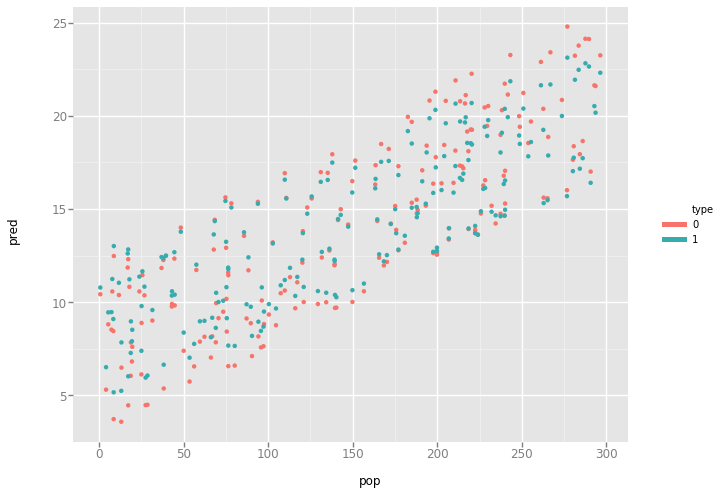

<ggplot: (299797459)>

In [135]:
# Create scatter plot and two regression models (scaling exponential) using ggplot
ggplot(result, aes(x='pop',y='pred',color='type')) +\
geom_point(colors='blue') 